### Ice hockey game outcome prediction and modelling.

##### In this Notebook, We will be modelling a prediction model for predicting game outcomes in NHL.

In [60]:
import warnings
warnings.filterwarnings("ignore")

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import log_loss, accuracy_score
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import OneHotEncoder,StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from sklearn import svm
from tensorflow.keras.wrappers import scikit_learn
from keras.constraints import maxnorm
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import json

In [2]:
import joblib

### Loading the scrapped dataset.

In [61]:
game_data=pd.read_csv('data/final_scrapped_data.csv')

##### Loading the features selected using feature_selector.

In [4]:
selected_features_40=pd.read_csv('data/selected_features_40.csv',names=['index','features'])

In [5]:
selected_features_40=list(selected_features_40['features'])

In [6]:
selected_features_5=pd.read_csv('data/selected_features_5.csv',names=['index','features'])

In [7]:
selected_features_5=list(selected_features_5['features'])

In [8]:
game_data.reset_index(inplace=True)

### EDA

In [9]:
game_data.head()

,index,Unnamed: 0,game_id,date,venue,home_team,away_team,start_time,home_score,away_score,...,guest_GA_Average_Average_pk_TeamMoingAverage_5,guest_xGA_Average_pk_TeamMoingAverage_40,guest_xGA_Average_pk_TeamMoingAverage_5,guest_previous_play,guest_previous_play_day,guest_BacktoBack,match_BacktoBack,year,home_team_label,away_team_label
0,0,0,2015020001,2015-10-07,Air Canada Centre,TOR,MTL,2015-10-07 23:00:00,1,3,...,0.059016,NaN,0.034656,2015-10-03,4 days,0.0,Neither,20152016,28,16
1,1,1,2015020002,2015-10-07,United Center,CHI,NYR,2015-10-08 00:00:00,2,3,...,0.048977,NaN,0.047899,2015-09-30,7 days,0.0,Neither,20152016,8,20
2,2,2,2015020003,2015-10-07,Scotiabank Saddledome,CGY,VAN,2015-10-08 02:00:00,1,5,...,0.033102,NaN,0.044389,2015-10-03,4 days,0.0,Neither,20152016,7,28
3,3,3,2015020004,2015-10-07,STAPLES Center,L.A,S.J,2015-10-08 02:30:00,1,5,...,0.029515,NaN,0.041484,2015-10-03,4 days,0.0,Neither,20152016,15,24
4,4,4,2015020005,2015-10-08,TD Garden,BOS,WPG,2015-10-08 23:00:00,2,6,...,0.059068,NaN,0.043809,2015-10-03,5 days,0.0,Neither,20152016,3,30


##### Home and guest team winning percentage over the last 6 years.

In [10]:
team_winning_percent=game_data['Host_won'].value_counts(ascending=True,normalize=True)

In [11]:
team_winning_percent

0    0.459202
1    0.540798
Name: Host_won, dtype: float64

In [12]:
team_winning_percent[0]=team_winning_percent[0]*100
team_winning_percent[1]=team_winning_percent[1]*100

In [13]:
team_winning_percent.to_csv("data/team_winning_percent.csv")

##### Looks like home team has an advantage over the guest team.

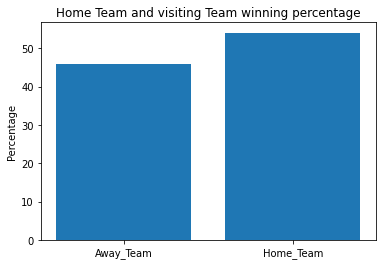

<Figure size 1440x2304 with 0 Axes>

In [14]:
team_status=['Away_Team','Home_Team']
plt.bar(team_status,[team_winning_percent[0],team_winning_percent[1]])
plt.ylabel("Percentage")
plt.title("Home Team and visiting Team winning percentage")
plt.figure(figsize=(20,32))
plt.show()

In [15]:
## home team has a winning percentage of 54% and away team has a winning percentage of 45%.

In [16]:
team_percent_year=game_data[game_data['year']>20152016].groupby('year')['Host_won'].value_counts(ascending=True,normalize = 'True')

In [17]:
team_percent_year

year      Host_won
20162017  0           0.435709
          1           0.564291
20172018  0           0.438869
          1           0.561131
20182019  0           0.471539
          1           0.528461
20192020  0           0.473077
          1           0.526923
20202021  0           0.464886
          1           0.535114
Name: Host_won, dtype: float64

In [18]:
team_percent_year=team_percent_year.unstack()

In [19]:
team_percent_year[0]=team_percent_year[0]*100
team_percent_year[1]=team_percent_year[1]*100

In [20]:
team_percent_year

Host_won,0,1
year,,
20162017,43.570904,56.429096
20172018,43.886926,56.113074
20182019,47.153900,52.846100
20192020,47.307692,52.692308
20202021,46.488625,53.511375


In [21]:
team_percent_year.to_csv("data/team_percent_year.csv")

##### In the last 6 season host team always performed better than the guest team. 

### Our Base and brute force model.

##### Using our analysis above, we took a baseline model that home team will win as the home team has performed better over the last 6 years.

In [23]:
game_data['Host_won'].value_counts(ascending=True,normalize=True)

0    0.459202
1    0.540798
Name: Host_won, dtype: float64

In [24]:
## Accuracy of our brute force model.

In [25]:
accuracy_score(game_data['Host_won'],np.ones(len(game_data)))

0.5407981698017286

In [26]:
log_loss(game_data['Host_won'],np.repeat(game_data['Host_won'].value_counts(normalize=True)[1],len(game_data)))

0.6898144953295867

##### Baseline model has produced an accuracy of 54%. So the model should achieve an accuracy of greater than 54% to be useful.

### Features for the model.

### We seperated the features into 40 and 5 rolling game average beacause NHL is a low scoring game and the data has a lot of varience. To smoothen out the varience we calculated 40 and 5 rolling game average for each feature.

##### We have decided to proceed with 40 game rolling average, because 40 games are good enough for a team to cover all the opponents a team might face.

##### We are going to use a lot of information about each game, Namely Corsi(Total number of shot attempts), Fenwick(Number of unblocked shot attempts), High density scoring chances, HDCSV((HDCA – HDGA)/HDCA), TOI (Time spent on Ice).

##### Obviously while predicting future matches we won't be having below data, So for any future match the two teams have a lot of match history for the last 6 years. We will be taking the average of all the matches two teams played against each other and feeding it to the model.
##### We were succesful in achieving an accuracy of 64%.

In [27]:
noncategorical=pd.read_csv("data/features_list.csv")

In [28]:
noncategorical=list(set(noncategorical.iloc[0]))

In [29]:
noncategorical=[x for x in noncategorical if (x in selected_features_40)]

In [30]:
moving_features=noncategorical+['match_BacktoBack']

In [31]:
game_data[noncategorical]=game_data[noncategorical].replace(to_replace =["-"],value=None)

In [32]:
len(game_data)

7868

##### Splitting the dataset into training and testing. We have dataset untill 2021 for training and validation testing.

##### For final prediction we are going to predict the games that are scheduled in 2022. 

In [33]:
years=[20152016,20162017,20172018,20182019,20192020,20202021]

In [34]:
X_train_40=game_data[game_data['year']!=years[-1]].dropna()
X_train_40=X_train_40[moving_features].dropna()

y_train=game_data[game_data['year']!=years[-1]].dropna()['Host_won']

X_test_40=game_data[game_data['year']==years[-1]]
X_test_40=X_test_40[moving_features]

y_test=game_data[game_data['year']==years[-1]]['Host_won']
y_test.shape

(1011,)

In [35]:
X_train_40[noncategorical]=X_train_40[noncategorical].astype(float)

In [36]:
X_test_40[noncategorical]=X_test_40[noncategorical].astype(float)

In [37]:
X_test_hat_40=X_test_40[:100]
y_test_hat=y_test[:100]

In [38]:
pred_df=game_data[game_data['year']==years[-1]].dropna().loc[:,['game_id','date','venue','home_team','away_team']]

### Logistic Regression for 40 rolling game average.

In [39]:
scaler=StandardScaler()

In [40]:
binary_pipeline=Pipeline(steps=[('scaler', scaler)])

In [41]:
non_binary_features=['match_BacktoBack']

In [42]:
ohe=OneHotEncoder(handle_unknown='ignore')

In [43]:
non_binary_pipeline = Pipeline(steps=[('ohe',ohe)])

In [44]:
model_classifier=LogisticRegression(max_iter=100000)

In [45]:
Feature_Transformer=ColumnTransformer(transformers=[('num',binary_pipeline,noncategorical),('cat',non_binary_pipeline,non_binary_features)])

In [46]:
model_pp=Pipeline(steps=[('preprocessor',Feature_Transformer),('logisticregression',model_classifier)])

In [47]:
model_Logistic=GridSearchCV(estimator=model_pp,param_grid={'logisticregression__solver' : ['lbfgs','liblinear','sag','saga'],'logisticregression__penalty':['l2'],'logisticregression__C': [0.00002,0.00001,0.1]
},cv=20,scoring=['neg_log_loss','accuracy'],refit='accuracy')

In [50]:
model_Logistic.fit(X_train_40,y_train)
joblib.dump(model_Logistic,'model_Logistic.pkl')

['model_Logistic.pkl']

##### Loading the saved model.

In [51]:
model_Logistic=joblib.load('saved_models/model_Logistic.pkl')

##### Testing the model.

In [52]:
prob_logistic=model_Logistic.predict_proba(X_test_hat_40)
accuracy_logistic=accuracy_score(y_test_hat,model_Logistic.predict(X_test_hat_40))
logloss_logistic=log_loss(y_test_hat,model_Logistic.predict_proba(X_test_hat_40))

In [53]:
print('Logistic Regression Accuracy:',accuracy_logistic*100)

Logistic Regression Accuracy: 63.0


##### Sample output of the model.

In [54]:
model_Logistic_output=pd.concat([pred_df,pd.DataFrame(prob_logistic,columns=['Away Win Probability','Home Win Probability'], index = y_test_hat.index)],axis=1)


In [55]:
model_Logistic_output.head()

,game_id,date,venue,home_team,away_team,Away Win Probability,Home Win Probability
6857,2.020020e+09,2021-01-13,Wells Fargo Center,PHI,PIT,0.399443,0.600557
6858,2.020020e+09,2021-01-13,Scotiabank Arena,TOR,MTL,0.317404,0.682596
6859,2.020020e+09,2021-01-13,Amalie Arena,T.B,CHI,0.126660,0.873340
6860,2.020020e+09,2021-01-13,Rogers Place,EDM,VAN,0.203724,0.796276
6861,2.020020e+09,2021-01-13,Ball Arena,COL,STL,0.775636,0.224364


### Ada Boost classifier for 40 rolling games.

In [84]:
model_classifier=AdaBoostClassifier()

In [85]:
n_estimators=[25]
learning_rate=[0.01,0.1,1]
base_estimator=[svm.SVC(probability=True , kernel='linear'), LogisticRegression()]
param_grid=dict(ada__n_estimators=n_estimators,ada__learning_rate=learning_rate,ada__base_estimator=base_estimator)

In [86]:
model_ada=GridSearchCV(estimator=Pipeline(steps=[('preprocessor', Feature_Transformer),('ada',model_classifier)]),param_grid=param_grid, cv=5, scoring=['neg_log_loss','accuracy'], refit='neg_log_loss')

In [87]:
model_ada.get_params

<bound method BaseEstimator.get_params of GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('scaler',
                                                                                          StandardScaler())]),
                                                                         ['guest_Fenwick%_SVA_TeamMoingAverage_40',
                                                                          'guest_SFGF%_SVA_TeamMoingAverage_40',
                                                                          'home_SFGF%_SVA_TeamMoingAverage_40',
                                                                          'guest_GF%_SVA_TeamMoingAverage_40',
                                                                          'home_GF%_SVA_TeamMoingAverage_40',
                              

##### Below code cell takes around 8 min to run. You can skip to the next cell where I will be loading the saved model.

In [59]:
model_ada.fit(X_train_40, y_train)
joblib.dump(model_ada,'saved_models/model_ada.pkl')

['saved_models/model_ada.pkl']

##### Loading the saved model.

In [62]:
model_ada=joblib.load('saved_models/model_ada.pkl')

##### Testing the model.

In [63]:
prob_adaboost=model_ada.predict_proba(X_test_40)
accuracy_adaboost=accuracy_score(y_test,model_ada.predict(X_test_40))
logloss_adaboost=log_loss(y_test,model_ada.predict_proba(X_test_40))


In [64]:
print('Ada boost classifier accuracy:',accuracy_adaboost*100)

Ada boost classifier accuracy: 68.5459940652819


##### Sample output of the model.

In [65]:
model_ada_output=pd.concat([pred_df,pd.DataFrame(prob_adaboost,columns=['Away Win Probability','Home Win Probability'],index=y_test.index)],axis=1)


In [66]:
model_ada_output.head()

,game_id,date,venue,home_team,away_team,Away Win Probability,Home Win Probability
6857,2.020020e+09,2021-01-13,Wells Fargo Center,PHI,PIT,0.457463,0.542537
6858,2.020020e+09,2021-01-13,Scotiabank Arena,TOR,MTL,0.424204,0.575796
6859,2.020020e+09,2021-01-13,Amalie Arena,T.B,CHI,0.320453,0.679547
6860,2.020020e+09,2021-01-13,Rogers Place,EDM,VAN,0.360610,0.639390
6861,2.020020e+09,2021-01-13,Ball Arena,COL,STL,0.608810,0.391190


##### Gradient Boosting classifier for prediction.

In [82]:
model=GradientBoostingClassifier()
n_estimators=[200, 400]
learning_rate=[.001,.01]
depth=[3,5]
param_grid=dict(gb__n_estimators=n_estimators,gb__learning_rate=learning_rate,gb__max_depth=depth)
model_gradient=GridSearchCV(estimator=Pipeline(steps=[('preprocessor', Feature_Transformer),('gb',model)]),param_grid=param_grid,cv=20,scoring=['neg_log_loss', 'accuracy'],refit='neg_log_loss')

##### Below code cell takes around 8 min to run. You can skip to the next cell where I will be loading the saved model.

In [83]:
model_gradient.fit(X_train_40,y_train)
joblib.dump(model_gradient,'saved_models/model_gradient.pkl')

['saved_models/model_gradient.pkl']

##### Loading the saved model.

In [69]:
model_gradient=joblib.load('saved_models/model_gradient.pkl')

##### Testing the model.

In [70]:
prob_gradient_boost=model_gradient.predict_proba(X_test_40)
accuracy__gradient_boost=accuracy_score(y_test,model_gradient.predict(X_test_40))
logloss_gradient_boost=log_loss(y_test,model_gradient.predict_proba(X_test_40))

In [71]:
print('Accuracy of gradient boosting model',accuracy__gradient_boost*100)

Accuracy of gradient boosting model 64.78733926805144


##### Sample output of the model.

In [72]:
gradient_40_output=pd.concat([pred_df,pd.DataFrame(prob_gradient_boost,columns=['Away Win Probability','Home Win Probability'],index=y_test.index)],axis=1)
gradient_40_output.head()

,game_id,date,venue,home_team,away_team,Away Win Probability,Home Win Probability
6857,2.020020e+09,2021-01-13,Wells Fargo Center,PHI,PIT,0.375653,0.624347
6858,2.020020e+09,2021-01-13,Scotiabank Arena,TOR,MTL,0.421033,0.578967
6859,2.020020e+09,2021-01-13,Amalie Arena,T.B,CHI,0.296171,0.703829
6860,2.020020e+09,2021-01-13,Rogers Place,EDM,VAN,0.259823,0.740177
6861,2.020020e+09,2021-01-13,Ball Arena,COL,STL,0.752150,0.247850


##### Neural Network model for game prediction.

In [73]:
x1=len(noncategorical)+4

In [77]:
def neural_network(optimizer,activation,neurons,dropout_rate,weight_constraint):
  nn_prediction=Sequential()
  nn_prediction.add(Dense(neurons, activation=activation, input_dim=x1, kernel_constraint=maxnorm(weight_constraint)))
  nn_prediction.add(Dropout(dropout_rate))
  nn_prediction.add(Dense(4, activation=activation))
  nn_prediction.add(Dense(1, activation = 'sigmoid'))
  nn_prediction.compile(optimizer=optimizer,loss='binary_crossentropy',metrics=['accuracy'])
  return nn_prediction

In [78]:
neural_pp=Pipeline(steps=[('preprocessor',Feature_Transformer),('nn',scikit_learn.KerasClassifier(build_fn=neural_network))])
optimizers=['RMSprop','Adam']
epochs=[10,12,16]
act_functions=['sigmoid','hard_sigmoid']
neurons=[18,24,30,36]
weights=[1,3,5]
drop_rate=[0.0,0.3,0.6]
param_grid = dict(nn__optimizer=optimizers, nn__epochs=epochs, nn__activation=act_functions,nn__neurons=neurons,nn__weight_constraint=weights,nn__dropout_rate=drop_rate)
model_neural=GridSearchCV(estimator=neural_pp,param_grid=param_grid,cv=5,scoring=['neg_log_loss','accuracy'],refit='neg_log_loss')

In [ ]:
model_neural.fit(X_train_40,y_train)
joblib.dump(model_neural,'saved_models/model_neural.pkl')

Streaming output truncated to the last 5000 lines.
64/64 [==============================] - 1s 2ms/step - loss: 0.6884 - accuracy: 0.5343
Epoch 2/12
64/64 [==============================] - 0s 2ms/step - loss: 0.6856 - accuracy: 0.5495
Epoch 3/12
64/64 [==============================] - 0s 2ms/step - loss: 0.6801 - accuracy: 0.5632
Epoch 4/12
64/64 [==============================] - 0s 2ms/step - loss: 0.6724 - accuracy: 0.5897
Epoch 5/12
64/64 [==============================] - 0s 2ms/step - loss: 0.6744 - accuracy: 0.5779
Epoch 6/12
64/64 [==============================] - 0s 2ms/step - loss: 0.6700 - accuracy: 0.5877
Epoch 7/12
64/64 [==============================] - 0s 2ms/step - loss: 0.6631 - accuracy: 0.5936
Epoch 8/12
64/64 [==============================] - 0s 2ms/step - loss: 0.6648 - accuracy: 0.6015
Epoch 9/12
64/64 [==============================] - 0s 2ms/step - loss: 0.6614 - accuracy: 0.5961
Epoch 10/12
64/64 [==============================] - 0s 2ms/step - loss: 0.656

['model_neural.pkl']

In [ ]:
### Loading the saved model.

In [ ]:
model_neural=joblib.load('saved_models/model_neural.pkl')

In [ ]:
prob_model_neural=model_neural.predict_proba(X_test_40)
output_model_neural=model_neural.predict(X_test_40)
accuracy_model_neural=accuracy_score(y_test,model_neural.predict(X_test_40))
logloss_model_neural=log_loss(y_test,model_neural.predict_proba(X_test_40))

In [ ]:
print('Accuracy of neural network:',accuracy_model_neural*100)

Accuracy of neural network: 69.04055390702275


In [ ]:
neuralnetwork_40_output=pd.concat([pred_df,pd.DataFrame(output_model_neural,columns = ['Prediction'], index = y_test.index ),pd.DataFrame(prob_model_neural,columns=['Away Win Probability','Home Win Probability'],index=y_test.index)],axis=1)

In [ ]:

print('Logistic Regression Metrics:')
print('Accuracy Score',accuracy_logistic)
print(' ')

print('Gradient Boosting Metrics:')
print('Accuracy Score',accuracy__gradient_boost)
print('')

print('Ada Boost Metrics:')
print('Ada Boost classifier with 40 rolling game average.')
print('Accuracy Score',accuracy_adaboost)
print(' ')
print('Neural  Netowork with 40 rolling game average.')
print('Accuracy Score',accuracy_model_neural)

#print(' ')

Logistic Regression Metrics:
Accuracy Score 0.63
 
Gradient Boosting Metrics:
Accuracy Score 0.6478733926805144

Ada Boost Metrics:
Ada Boost classifier with 40 rolling game average.
Accuracy Score 0.6864490603363007
 
Neural  Netowork with 40 rolling game average.
Accuracy Score 0.6904055390702275


### Neuralnetwork showed the highest accuracy.

In [ ]:
labelencoder=LabelEncoder()

In [ ]:
team_label=labelencoder.fit_transform(game_data['home_team'].unique())

In [ ]:
team_label_dict={}
for i in range(len(team_label)):
  team_label_dict[game_data['home_team'].unique()[i]]=team_label[i]

In [ ]:
game_data_filtered=game_data[game_data['year']!=20202021].dropna()

In [ ]:
dummy_columns=noncategorical

In [ ]:
dummy_columns=list(set(dummy_columns))

### Testing for NHL matches on March 26, March 27.

In [ ]:
matches_mar_26={0:["NYI","BOS"],1:["T.B","DET"],2:["CHI","VGK"],3:["FLA","OTT"],4:["VAN","DAL"],5:["N.J","WSH"],6:["TOR","MTL"],7:["CAR","STL"],8:["CBJ","MIN"],
                9:["EDM","CGY"],10:["ANA","S.J"]}
matches_mar_26_labels={0:["NYI","BOS"],1:["T.B","DET"],2:["CHI","VGK"],3:["FLA","OTT"],4:["VAN","DAL"],5:["N.J","WSH"],6:["TOR","MTL"],7:["CAR","STL"],8:["CBJ","MIN"],
                9:["EDM","CGY"],10:["ANA","S.J"]}
for i in range(len(matches_mar_26)):
  matches_mar_26[i][0]=team_label_dict[matches_mar_26[i][0]]
  matches_mar_26[i][1]=team_label_dict[matches_mar_26[i][1]]

In [ ]:
matches_mar_27={0:["T.B","NYI"],1:["BUF","NYR"],2:["DET","PIT"],3:["PHI","NSH"],4:["COL","MIN"],5:["ARI","WPG"],6:["MTL","N.J"],7:["FLA","TOR"]}
matches_mar_27_labels={0:["T.B","NYI"],1:["BUF","NYR"],2:["DET","PIT"],3:["PHI","NSH"],4:["COL","MIN"],5:["ARI","WPG"],6:["MTL","N.J"],7:["FLA","TOR"]}
for i in range(len(matches_mar_27)):
  matches_mar_27[i][0]=team_label_dict[matches_mar_27[i][0]]
  matches_mar_27[i][1]=team_label_dict[matches_mar_27[i][1]]

In [ ]:
X_hat_40=game_data.dropna()
X_hat_40=X_hat_40[dummy_columns+['match_BacktoBack']]

In [ ]:
dummy_df_1=pd.DataFrame(columns=dummy_columns+['match_BacktoBack'])
dummy_df_2=pd.DataFrame(columns=dummy_columns+['match_BacktoBack'])

In [ ]:
x5=[]
for i in range(len(matches_mar_26)):
  x1=matches_mar_26[i][0]
  x2=matches_mar_26[i][1]
  #print(x1,x2)
  x3=X_hat_40[X_hat_40['away_team_label']==x1]
  x4=x3[x3['home_team_label']==x2]
  #print(x4.shape)
  x5=x4[dummy_columns]
  #print(x5.shape)
  x5=x5.astype(float)
  x5=x5.mean(numeric_only=True)
  #print(x5.shape)
  x5=x5.reset_index(drop=True)
  x5=pd.DataFrame(x5)
  x5=x5.T
  #print(x5.shape)
  x5.columns=dummy_columns
  x5['match_BacktoBack']=X_test_hat_40.iloc[i]['match_BacktoBack']
  dummy_df_1=dummy_df_1.append(x5)

In [ ]:
x5=[]
for i in range(len(matches_mar_27)):
  x1=matches_mar_27[i][0]
  x2=matches_mar_27[i][1]
  #print(x1,x2)
  x3=X_hat_40[X_hat_40['away_team_label']==x1]
  x4=x3[x3['home_team_label']==x2]
  #print(x4.shape)
  x5=x4[dummy_columns]
  #print(x5.shape)
  x5=x5.astype(float)
  x5=x5.mean(numeric_only=True)
  #print(x5.shape)
  x5=x5.reset_index(drop=True)
  x5=pd.DataFrame(x5)
  x5=x5.T
  #print(x5.shape)
  x5.columns=dummy_columns
  x5['match_BacktoBack']=X_test_hat_40.iloc[i]['match_BacktoBack']
  dummy_df_2=dummy_df_2.append(x5)

In [ ]:
team_names=open("data/teamshortids.json")
team_names=json.load(team_names)

In [ ]:
team_names_inv={v:k for k, v in team_names.items()}

In [ ]:
team_names_inv['ANA']

'Anaheim Ducks'

In [ ]:
home_team_list_26=[]
away_team_list_26=[]
a_vs_b_list_26=[]
for i in range(len(matches_mar_26_labels)):
  home_team_list_26.append(matches_mar_26_labels[i][1])
  away_team_list_26.append(matches_mar_26_labels[i][0])
  a_vs_b_list_26.append(team_names_inv[matches_mar_26_labels[i][1]]+' (Home)'+' vs '+team_names_inv[matches_mar_26_labels[i][0]]+' (Away)')

In [ ]:
home_team_list_27=[]
away_team_list_27=[]
a_vs_b_list_27=[]
for i in range(len(matches_mar_27_labels)):
  home_team_list_27.append(matches_mar_27_labels[i][1])
  away_team_list_27.append(matches_mar_27_labels[i][0])
  a_vs_b_list_27.append(team_names_inv[matches_mar_27_labels[i][1]]+' (Home)'+' vs '+team_names_inv[matches_mar_27_labels[i][0]]+' (Away)')

In [ ]:
dummy_df_1[noncategorical]=dummy_df_1[noncategorical].replace(to_replace=np.nan,value=None)
dummy_df_2[noncategorical]=dummy_df_2[noncategorical].replace(to_replace=np.nan,value=None)

In [ ]:
output_mar26=model_neural.predict(dummy_df_1)
prob_mar26=model_neural.predict_proba(dummy_df_1)

In [ ]:
output_mar27=model_neural.predict(dummy_df_2)
prob_mar27=model_neural.predict_proba(dummy_df_2)

In [ ]:
prediction_map={0:"Guest",1:"Home"}
prediction_list_26=[]
prediction_list_27=[]
for i in range(len(prob_mar26)):
  prediction_list_26.append(prediction_map[output_mar26[i][0]])

for i in range(len(prob_mar27)):
  prediction_list_27.append(prediction_map[output_mar27[i][0]])

In [ ]:
final_output_26=pd.DataFrame([])
final_output_26['Guest_Team']=away_team_list_26
final_output_26['Home_Team']=home_team_list_26
final_output_26['Teams']=a_vs_b_list_26
final_output_27=pd.DataFrame([])
final_output_27['Guest_Team']=away_team_list_27
final_output_27['Home_Team']=home_team_list_27
final_output_27['Teams']=a_vs_b_list_27

In [ ]:
final_output_26.shape

(11, 3)

In [ ]:
mar_26_prediction=pd.concat([final_output_26,pd.DataFrame(prob_mar26,columns=['Guest Win Probability','Home Win Probability'])],axis=1)

In [ ]:
mar_27_prediction=pd.concat([final_output_27,pd.DataFrame(prob_mar27,columns=['Guest Win Probability','Home Win Probability'])],axis=1)

In [ ]:
mar_27_prediction['date']='mar_27'
mar_26_prediction['date']='mar_26'

In [ ]:
mar_26_prediction

,Guest_Team,Home_Team,Teams,Guest Win Probability,Home Win Probability,date
0,NYI,BOS,Boston Bruins (Home) vs New York Islanders (Away),0.247766,0.752234,mar_26
1,T.B,DET,Detroit Red Wings (Home) vs Tampa Bay Lightnin...,0.550594,0.449406,mar_26
2,CHI,VGK,Vegas Golden Knights (Home) vs Chicago Blackha...,0.550594,0.449406,mar_26
3,FLA,OTT,Ottawa Senators (Home) vs Florida Panthers (Away),0.739240,0.260760,mar_26
4,VAN,DAL,Dallas Stars (Home) vs Vancouver Canucks (Away),0.739240,0.260760,mar_26
5,N.J,WSH,Washington Capitals (Home) vs New Jersey Devil...,0.743664,0.256336,mar_26
6,TOR,MTL,Montreal Canadiens (Home) vs Toronto Maple Lea...,0.247461,0.752539,mar_26
7,CAR,STL,St Louis Blues (Home) vs Carolina Hurricanes (...,0.347043,0.652957,mar_26
8,CBJ,MIN,Minnesota Wild (Home) vs Columbus Blue Jackets...,0.347043,0.652957,mar_26
9,EDM,CGY,Calgary Flames (Home) vs Edmonton Oilers (Away),0.597983,0.402017,mar_26


In [ ]:
mar_27_prediction

,Guest_Team,Home_Team,Teams,Guest Win Probability,Home Win Probability,date
0,T.B,NYI,New York Islanders (Home) vs Tampa Bay Lightni...,0.450454,0.549546,mar_27
1,BUF,NYR,New York Rangers (Home) vs Buffalo Sabres (Away),0.450454,0.549546,mar_27
2,DET,PIT,Pittsburgh Penguins (Home) vs Detroit Red Wing...,0.249696,0.750304,mar_27
3,PHI,NSH,Nashville Predators (Home) vs Philadelphia Fly...,0.249890,0.750110,mar_27
4,COL,MIN,Minnesota Wild (Home) vs Colorado Avalanche (A...,0.409680,0.590320,mar_27
5,ARI,WPG,Winnipeg Jets (Home) vs Arizona Coyotes (Away),0.409680,0.590320,mar_27
6,MTL,N.J,New Jersey Devils (Home) vs Montreal Canadiens...,0.409680,0.590320,mar_27
7,FLA,TOR,Toronto Maple Leafs (Home) vs Florida Panthers...,0.184530,0.815470,mar_27


In [ ]:
for i in range(len(mar_26_prediction)):
      mar_26_prediction['Guest_Team'][i]=team_names_inv[mar_26_prediction['Guest_Team'][i]]
  mar_26_prediction['Home_Team'][i]=team_names_inv[mar_26_prediction['Home_Team'][i]]
for i in range(len(mar_27_prediction)):
  mar_27_prediction['Guest_Team'][i]=team_names_inv[mar_27_prediction['Guest_Team'][i]]
  mar_27_prediction['Home_Team'][i]=team_names_inv[mar_27_prediction['Home_Team'][i]]

In [ ]:
mar_27_prediction

,Guest_Team,Home_Team,Teams,Guest Win Probability,Home Win Probability,date
0,Tampa Bay Lightning,New York Islanders,New York Islanders (Home) vs Tampa Bay Lightni...,0.450454,0.549546,mar_27
1,Buffalo Sabres,New York Rangers,New York Rangers (Home) vs Buffalo Sabres (Away),0.450454,0.549546,mar_27
2,Detroit Red Wings,Pittsburgh Penguins,Pittsburgh Penguins (Home) vs Detroit Red Wing...,0.249696,0.750304,mar_27
3,Philadelphia Flyers,Nashville Predators,Nashville Predators (Home) vs Philadelphia Fly...,0.249890,0.750110,mar_27
4,Colorado Avalanche,Minnesota Wild,Minnesota Wild (Home) vs Colorado Avalanche (A...,0.409680,0.590320,mar_27
5,Arizona Coyotes,Winnipeg Jets,Winnipeg Jets (Home) vs Arizona Coyotes (Away),0.409680,0.590320,mar_27
6,Montreal Canadiens,New Jersey Devils,New Jersey Devils (Home) vs Montreal Canadiens...,0.409680,0.590320,mar_27
7,Florida Panthers,Toronto Maple Leafs,Toronto Maple Leafs (Home) vs Florida Panthers...,0.184530,0.815470,mar_27


In [ ]:
mar_26_27=pd.concat([mar_26_prediction,mar_27_prediction])

In [ ]:
mar_26_27=mar_26_27.reset_index()

In [ ]:
mar_26_27=mar_26_27.drop('index',axis=1)

In [ ]:
mar_26_27

,Guest_Team,Home_Team,Teams,Guest Win Probability,Home Win Probability,date
0,New York Islanders,Boston Bruins,Boston Bruins (Home) vs New York Islanders (Away),0.247766,0.752234,mar_26
1,Tampa Bay Lightning,Detroit Red Wings,Detroit Red Wings (Home) vs Tampa Bay Lightnin...,0.550594,0.449406,mar_26
2,Chicago Blackhawks,Vegas Golden Knights,Vegas Golden Knights (Home) vs Chicago Blackha...,0.550594,0.449406,mar_26
3,Florida Panthers,Ottawa Senators,Ottawa Senators (Home) vs Florida Panthers (Away),0.739240,0.260760,mar_26
4,Vancouver Canucks,Dallas Stars,Dallas Stars (Home) vs Vancouver Canucks (Away),0.739240,0.260760,mar_26
5,New Jersey Devils,Washington Capitals,Washington Capitals (Home) vs New Jersey Devil...,0.743664,0.256336,mar_26
6,Toronto Maple Leafs,Montreal Canadiens,Montreal Canadiens (Home) vs Toronto Maple Lea...,0.247461,0.752539,mar_26
7,Carolina Hurricanes,St Louis Blues,St Louis Blues (Home) vs Carolina Hurricanes (...,0.347043,0.652957,mar_26
8,Columbus Blue Jackets,Minnesota Wild,Minnesota Wild (Home) vs Columbus Blue Jackets...,0.347043,0.652957,mar_26
9,Edmonton Oilers,Calgary Flames,Calgary Flames (Home) vs Edmonton Oilers (Away),0.597983,0.402017,mar_26


In [ ]:
mar_26_27.to_csv('data/mar_26_27.csv')

##### Feature Importance. What features are most affecting the model. Team coaches and managers can benefit from the metrics to improve the team performance. 

In [ ]:
len(model_gradient.best_estimator_._final_estimator.feature_importances_)

50

In [ ]:
model_gradient.best_estimator_._final_estimator.feature_importances_
feature_importance=pd.DataFrame([])
feature_list=[]
imp_list=[]
for i in range(len(noncategorical)):
  feature_list.append(noncategorical[i])
  imp_list.append(model_gradient.best_estimator_._final_estimator.feature_importances_[i])
feature_importance['feature']=feature_list
feature_importance['imp']=imp_list

feature_importance=feature_importance.sort_values(by=['imp'],ascending=False)
feature_importance=feature_importance.reset_index()
feature_importance=feature_importance[['feature','imp']]
feature_importance.to_csv('data/feature_importance.csv')
feature_importance.head(20)

,feature,imp
0,home_GF_Average_Average_pp_TeamMoingAverage_40,0.176586
1,home_CF%,0.090153
2,guest_GA_pk_TeamMoingAverage_40,0.071755
3,guest_CF,0.030551
4,home_SF,0.029610
5,guest_xGA_pk_TeamMoingAverage_40,0.028138
6,home_SF_SVA_TeamMoingAverage_40,0.026286
7,home_SA_SVA_TeamMoingAverage_40,0.025130
8,home_CA_SVA_TeamMoingAverage_40,0.025019
9,guest_FF%,0.023463
